In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB3

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Generate train data paths with labels
train_data_dir = "/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patches"
filepaths = []  
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)
# print(labels)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

,filepaths,labels
0,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Normal(Healthy skin)
1,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Normal(Healthy skin)
2,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Normal(Healthy skin)
3,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Normal(Healthy skin)
4,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Normal(Healthy skin)
...,...,...
1050,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Abnormal(Ulcer)
1051,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Abnormal(Ulcer)
1052,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Abnormal(Ulcer)
1053,/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patc...,Abnormal(Ulcer)


In [3]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.6, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [4]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 633 validated image filenames belonging to 2 classes.
Found 211 validated image filenames belonging to 2 classes.
Found 211 validated image filenames belonging to 2 classes.


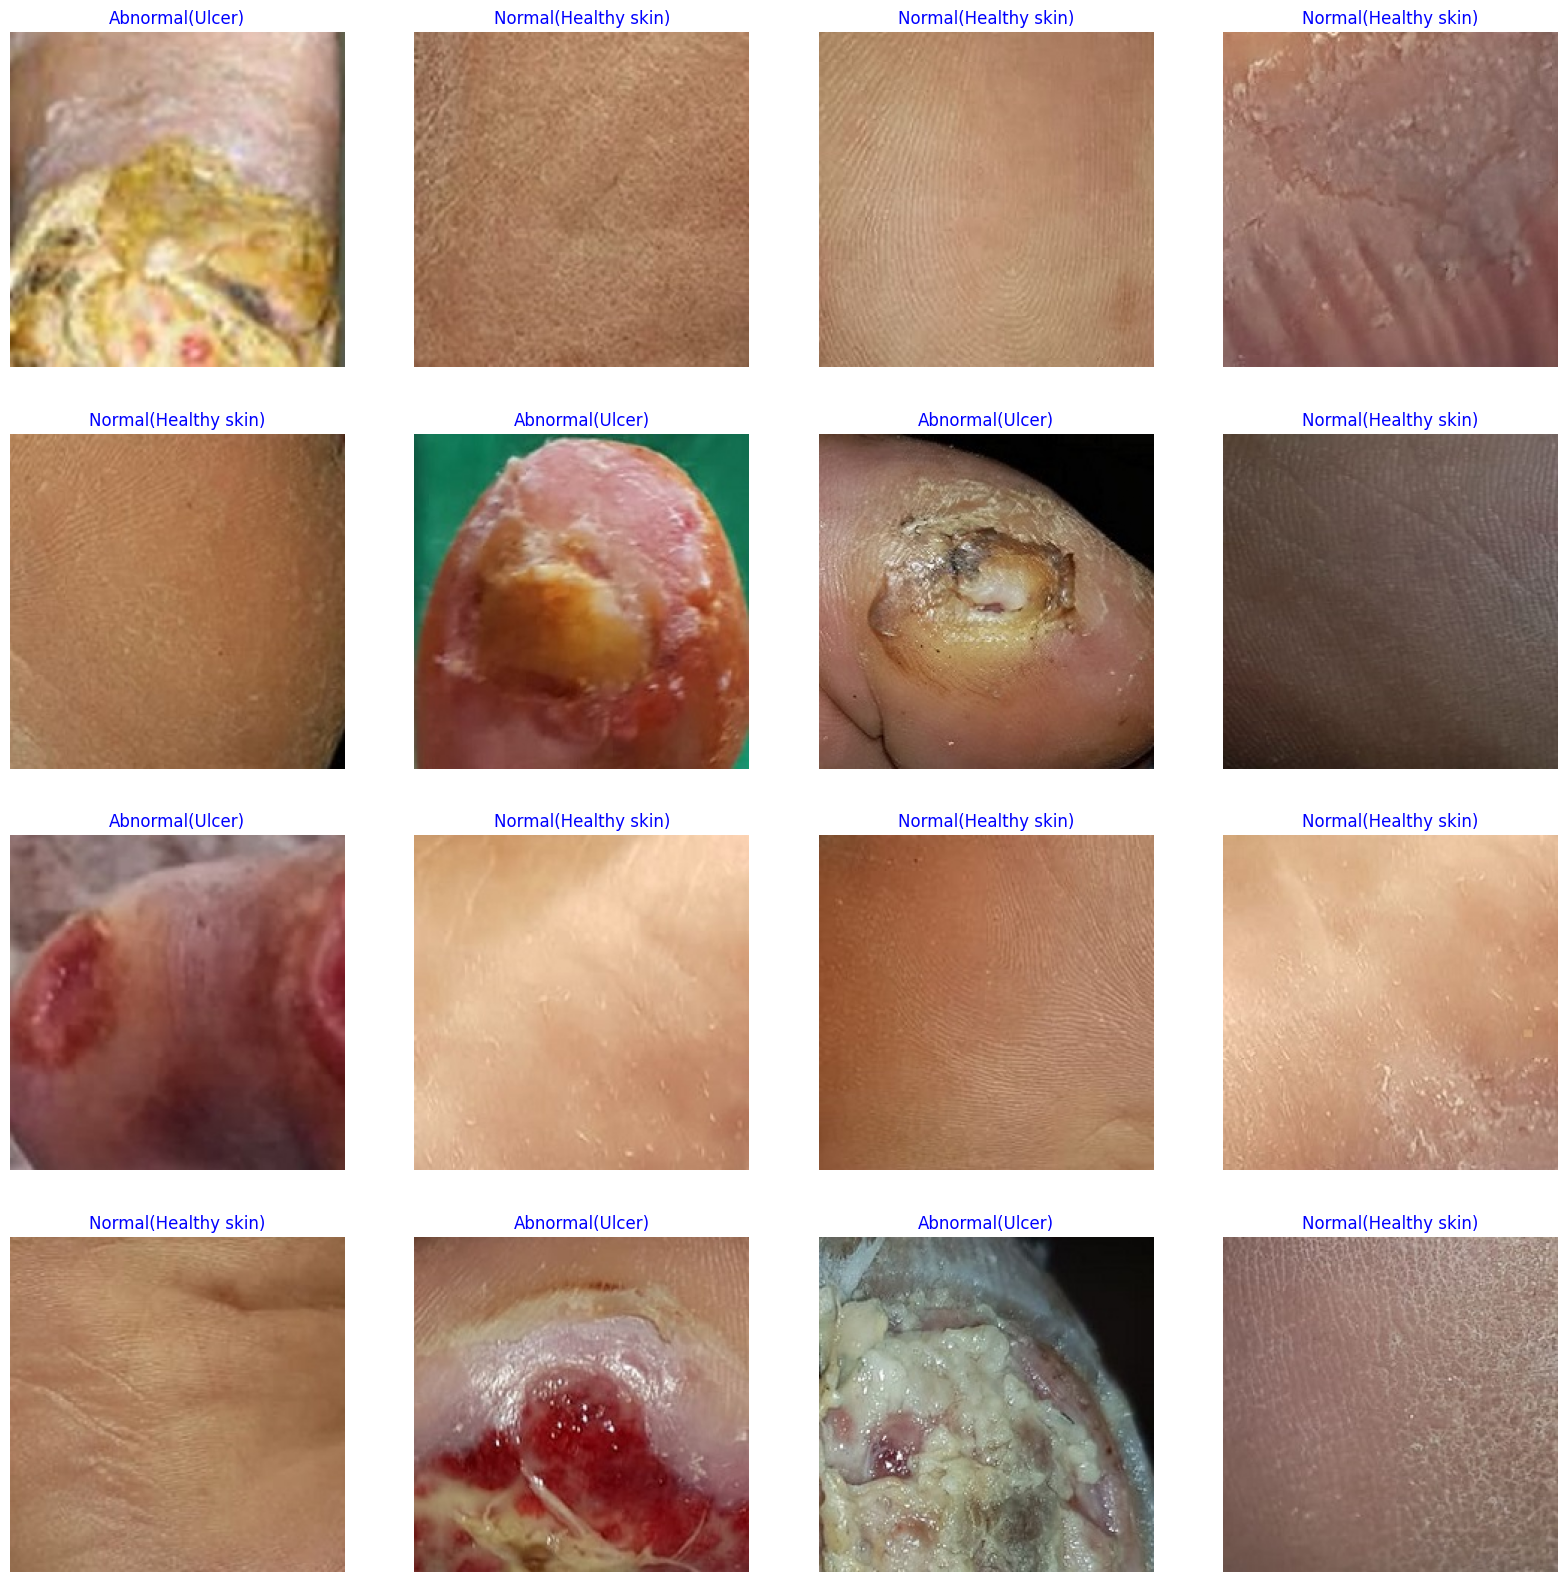

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [6]:
# Assuming train_gen is your training data generator
class_labels = list(train_gen.class_indices.keys())  # Extract class labels directly from the training generator

# Display the class labels to verify
print(f"Class labels: {class_labels}")

Class labels: ['Abnormal(Ulcer)', 'Normal(Healthy skin)']


In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu', input_shape=img_shape),
    Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(265, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')  # Adjust the number of units to match the number of classes
])
model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'],) 

model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 265)                 │       6,648,585 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,380,427 (81.56 MB)

 Trainable params: 21,380,427 (81.56 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Instantiate the EarlyStopping callback  
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor  
                               patience=5,         # Number of epochs with no improvement after which training will be stopped  
                               verbose=1,         # Print messages when stopping  
                               restore_best_weights=True)  # Restore the weights of the best epoch  

# Proceed with training  
history = model.fit(  
    x=train_gen,  
    epochs=50,  # Set maximum number of epochs  
    validation_data=valid_gen,  
    callbacks=[early_stopping],  # Add the EarlyStopping callback here  
    shuffle=False  
)  

# Suppress warnings if needed  
import warnings  
warnings.filterwarnings("ignore")  

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.5434 - loss: 87.4761 - val_accuracy: 0.4408 - val_loss: 0.6937
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5596 - loss: 0.6912 - val_accuracy: 0.6540 - val_loss: 0.6808
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5328 - loss: 0.6935 - val_accuracy: 0.4408 - val_loss: 0.6955
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5892 - loss: 0.6730 - val_accuracy: 0.8152 - val_loss: 0.4767
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8321 - loss: 0.4444 - val_accuracy: 0.9336 - val_loss: 0.2186
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9024 - loss: 0.2626 - val_accuracy: 0.9621 - val_loss: 0.1383
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9651 - loss: 0.1300 - val_accuracy: 0.9526 - val_loss: 0.1613
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9516 - loss: 0.1588 - val_accuracy: 

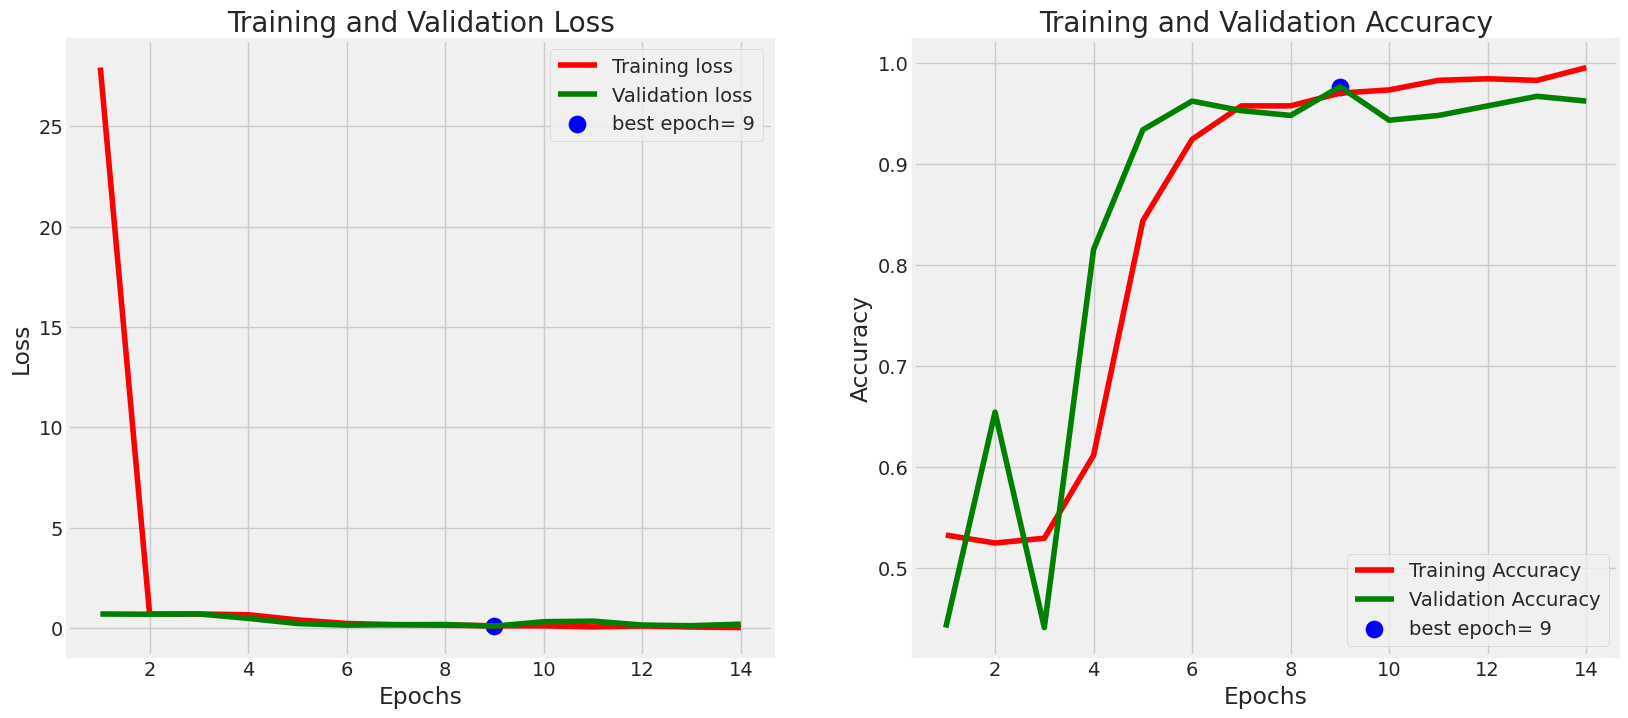

In [9]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9775 - loss: 0.0527  
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.0904 
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9806 - loss: 0.0612
Train Loss:  0.05297001078724861
Train Accuracy:  0.9778831005096436
--------------------
Validation Loss:  0.0894455686211586
Validation Accuracy:  0.9763033390045166
--------------------
Test Loss:  0.10483565181493759
Test Accuracy:  0.971563994884491


In [11]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


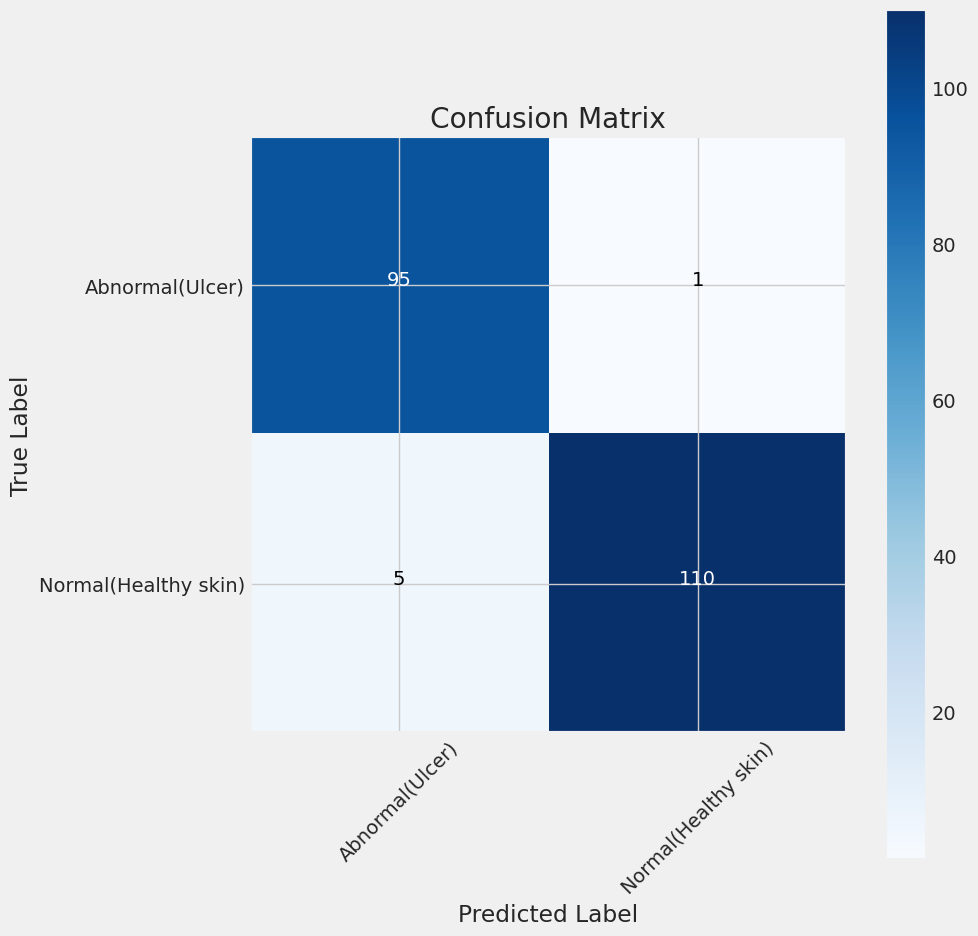

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

     Abnormal(Ulcer)       0.95      0.99      0.97        96
Normal(Healthy skin)       0.99      0.96      0.97       115

            accuracy                           0.97       211
           macro avg       0.97      0.97      0.97       211
        weighted avg       0.97      0.97      0.97       211



In [14]:
model.save('Diabetic_Foot_Ulcer4.h5')

In [15]:
# # Adjust the file path if necessary  
# model_path = "/kaggle/working/Diabetic Foot Ulcer2.h5"  

# # Load the model  
# loaded_model = tf.keras.models.load_model(model_path, compile=False)  

# # Compile the model again if needed  
# loaded_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),  
#                      loss='categorical_crossentropy',   
#                      metrics=['accuracy'])  

In [16]:
# import os
# file_path = '/kaggle/working/Diabetic_Foot_Ulcer4.h5'
# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"File {file_path} has been removed.")
# else:
#     print("File not found.")

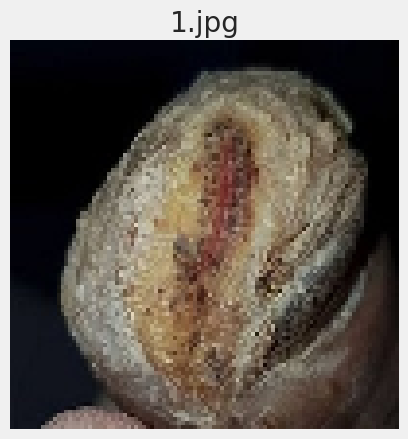

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Predicted Class: Abnormal(Ulcer) (1.00 confidence)
Prediction probabilities: [[1.000000e+00 2.803206e-11]]
--------------------------------------------------


In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image

# Load trained model
model = tf.keras.models.load_model("Diabetic_Foot_Ulcer4.h5")

# Use same class order as in training
class_labels = ['Abnormal(Ulcer)', 'Normal(Healthy skin)']

# Function to preprocess the image (NO Normalization)
def preprocess_image(img_path, img_size):
    img = keras_image.load_img(img_path, target_size=img_size)  # Load and resize
    img = keras_image.img_to_array(img)  # Convert to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img  # No / 255.0 to match training

# Function to predict and display image
def predict_and_display_image(img_path, model, img_size=(224, 224)):
    input_img = preprocess_image(img_path, img_size)

    # Display image
    img_array = keras_image.img_to_array(keras_image.load_img(img_path, target_size=(100, 100)))
    plt.imshow(img_array.astype('uint8'))
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

    # Make a prediction
    predictions = model.predict(input_img)
    predicted_class = np.argmax(predictions)  # Get class with highest probability
    confidence = np.max(predictions)  # Get confidence score

    # Get correct class name
    predicted_label = class_labels[predicted_class]  
    print(f"Predicted Class: {predicted_label} ({confidence:.2f} confidence)")
    print("Prediction probabilities:", predictions)
    print("-" * 50)

# Test image path
img_path = "/kaggle/input/diabetic-foot-ulcer-dfu/DFU/Patches/Abnormal(Ulcer)/1.jpg"

# Run prediction
predict_and_display_image(img_path, model, img_size=(224, 224))

